# Finding Shaker table sync cues in ACC measurements from Equivitals

having issues with datetime 
https://pandas.pydata.org/docs/whatsnew/v2.2.0.html#datetimelike

https://github.com/pandas-dev/pandas/issues/52895
Work around for now: plt.plot(df.col_in_dt,df.col_signal)

For now, convert all datetimes to utc with .tz_localize(None), .dt.tz_localize(None), and custom remove_tz_from_dataframe function

In [4]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

In [5]:
pip show pandas | grep Version

Version: 2.2.1
Note: you may need to restart the kernel to use updated packages.


In [6]:
%load_ext autoreload
%autoreload 1
%aimport qex
%aimport al

In [7]:
%reload_ext autoreload

In [8]:
def remove_tz_from_dataframe(df_in):
    df = df_in.copy()
    col_times = [ col for col in df.columns if any([isinstance(x, pd.Timestamp) for x in df[col]])]
    for col in col_times:
        df[col] = pd.to_datetime(df[col],format='ISO8601') 
        df[col] = df[col].dt.tz_localize(None) 
    return df

def xcov(datax, datay,maxlag=10):
    # https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas
    rs = []
    for i in range(-maxlag,maxlag):
        rs.append(datax.corr(datay.shift(i)))
    return rs

In [9]:
def min_align(ACC,cue,prelim_synch_time,max_offs):   
    sampleshift_s = cue['sTime'].diff().median()
    sf = np.round(1/sampleshift_s)
    t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
    c_type = 'taps'
    xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
              pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
#     print(xrange)
    sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
    cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

    max_offs = 5
    X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
    sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
    sig_v = X['signal']
    f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
    new_sig = f(sig_sTime)
    signal = pd.DataFrame()
    signal.loc[:,'signal'] = new_sig
    signal.loc[signal['signal'].isna(),'signal'] = 0
    # scale signals a little 
    M = signal['signal'].quantile(0.998)
    signal.loc[:,'signal']  = signal['signal']/M
    signal.loc[signal['signal']>1,'signal'] = 1
    signal.loc[signal['signal']<0,'signal'] = 0
    signal.loc[:,'sTime'] = sig_sTime
    signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
    length = np.min([len(signal),len(cue)]) # they should match, but just in case

    xcorred = pd.DataFrame()
    max_offs = 5
    xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
    xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
    max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
    max_r = xcorred['r'].max()
    cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

    fig, axes = plt.subplots(3,1,figsize=(12,4))
    ax =axes[0]
    cue.plot(x='sTime',y=c_type,ax=ax)
    signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
    ax.set_title('ACC synch alignment')
    ax.set_ylabel('Unaligned')
    ax.legend()

    ax = axes[1]
    xcorred.plot(x='shift_s',y='r',ax=ax)
    ax.plot(max_shift,max_r,'ro')
    ax.set_ylim([0,1])
    ax.grid(True)
    ax.set_xticklabels('')

    ax = axes[2]
    ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
    ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
    ax.xaxis.set_tick_params(rotation=40)

    ax.grid(True)
    ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
    ax.set_ylabel('Aligned')
    ax.set_xlabel('dev_Time')
    plt.show()

    cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
    C_results = {'best_dt': cue_time,'best_s': max_shift,'best_r': max_r,'CCC':xcorred,'cue':cue,'signal':signal}
    return C_results

# Get the cues for Saturday March 9th

In [10]:
synch_times = {}

In [11]:
cue_times = pd.read_csv('./outfiles/cue1_20240309.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
Sync_Zero_Time_s = cue_times.loc[cue_times['peaks']==1,'S_AudioTime'].iloc[0]
Sync_Zero_Time_dt = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
synch_times['cue1_20240309'] = Sync_Zero_Time_dt
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

20.294512    0.0000
22.520726    2.2262
24.494422    4.1999
26.572608    6.2781
Name: SyncTime, dtype: float64

In [12]:
cue_times = pd.read_csv('./outfiles/cue1_20240309.csv',index_col = 0) #SV alignment for beeps

cue_times

,rms,peaks,DateTime
19.000000,0.000232,0,2024-03-09 12:29:19+00:00
19.002902,0.000316,0,2024-03-09 12:29:19.002902494+00:00
19.005805,0.000358,0,2024-03-09 12:29:19.005804989+00:00
19.008707,0.000363,0,2024-03-09 12:29:19.008707483+00:00
19.011610,0.000339,0,2024-03-09 12:29:19.011609977+00:00
...,...,...,...
26.987664,0.000580,0,2024-03-09 12:29:26.987664399+00:00
26.990567,0.000303,0,2024-03-09 12:29:26.990566893+00:00
26.993469,0.000437,0,2024-03-09 12:29:26.993469388+00:00
26.996372,0.000518,0,2024-03-09 12:29:26.996371882+00:00


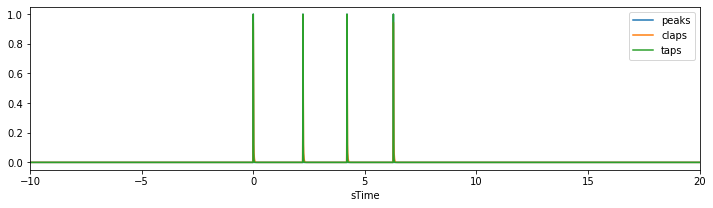

In [13]:
CueT={}
sf = 256
t_range= [-10,20]
cue = al.cue_template_make(peak_times,sf,t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])
plt.xlim(t_range)

CueT['cue1_20240309'] = cue

In [14]:
Sync_Zero_Time_dt

Timestamp('2024-03-09 12:29:20.294512472')

In [15]:
cue_times = pd.read_csv('./outfiles/cue2_20240309.csv',index_col = 0) #SV alignment for beeps
cue_times['DateTime'] = pd.to_datetime(cue_times['DateTime'],format='ISO8601')
cue_times['S_AudioTime'] = np.round(cue_times.index,4)
synch_times['cue2_20240309'] = cue_times.loc[cue_times['peaks']==1,'DateTime'].iloc[0].tz_localize(None) 
cue_times['SyncTime'] = cue_times['S_AudioTime']-Sync_Zero_Time_s # zero on onset of first synch cue
peak_times = cue_times.loc[cue_times['peaks']==1,'SyncTime']
peak_times

15251.326465    15231.0320
15252.856079    15232.5616
15254.342156    15234.0477
15255.831136    15235.5366
Name: SyncTime, dtype: float64

In [16]:
cue_times

,rms,peaks,DateTime,S_AudioTime,SyncTime
15249.971000,0.000231,0,2024-03-09 16:43:09.971000+00:00,15249.9710,15229.6765
15249.973902,0.000309,0,2024-03-09 16:43:09.973902494+00:00,15249.9739,15229.6794
15249.976805,0.000446,0,2024-03-09 16:43:09.976804989+00:00,15249.9768,15229.6823
15249.979707,0.000425,0,2024-03-09 16:43:09.979707483+00:00,15249.9797,15229.6852
15249.982610,0.000442,0,2024-03-09 16:43:09.982609977+00:00,15249.9826,15229.6881
...,...,...,...,...,...
15257.958664,0.003089,0,2024-03-09 16:43:17.958664399+00:00,15257.9587,15237.6642
15257.961567,0.003260,0,2024-03-09 16:43:17.961566893+00:00,15257.9616,15237.6671
15257.964469,0.003411,0,2024-03-09 16:43:17.964469388+00:00,15257.9645,15237.6700
15257.967372,0.003229,0,2024-03-09 16:43:17.967371882+00:00,15257.9674,15237.6729


In [17]:
peak_times

15251.326465    15231.0320
15252.856079    15232.5616
15254.342156    15234.0477
15255.831136    15235.5366
Name: SyncTime, dtype: float64

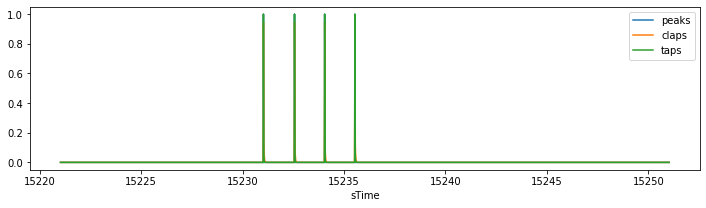

In [18]:
cue = al.cue_template_make(peak_times,int(sf),t_range)
cue.plot(x='sTime',y=['peaks','claps','taps'],figsize=[12,3])

CueT['cue2_20240309'] = cue

In [19]:
synch_times

{'cue1_20240309': Timestamp('2024-03-09 12:29:20.294512472'),
 'cue2_20240309': Timestamp('2024-03-09 16:43:11.326464853')}

In [17]:
CueT

{'cue1_20240309':           sTime  peaks           taps  claps
 0    -10.000000      0   0.000000e+00    0.0
 1     -9.996094      0   0.000000e+00    0.0
 2     -9.992188      0   0.000000e+00    0.0
 3     -9.988281      0   0.000000e+00    0.0
 4     -9.984375      0   0.000000e+00    0.0
 ...         ...    ...            ...    ...
 7675  19.980469      0  9.881313e-324    0.0
 7676  19.984375      0  9.881313e-324    0.0
 7677  19.988281      0  9.881313e-324    0.0
 7678  19.992188      0   0.000000e+00    0.0
 7679  19.996094      0   0.000000e+00    0.0
 
 [7680 rows x 4 columns],
 'cue2_20240309':              sTime  peaks           taps  claps
 0     15221.032000      0   0.000000e+00    0.0
 1     15221.035906      0   0.000000e+00    0.0
 2     15221.039812      0   0.000000e+00    0.0
 3     15221.043719      0   0.000000e+00    0.0
 4     15221.047625      0   0.000000e+00    0.0
 ...            ...    ...            ...    ...
 7675  15251.012469      0  9.881313e-324  

## Load example of ACC data

In [81]:
# note special complications: VN104 was not returned on march 04, recorded through to late on march 05
# LS404 was also late on March 05. These need to be synched with Synch 3. 

data_dir='/Volumes/TaeTae/Stavangar/20240307/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='VN101'
df_datafiles.loc[pid,:]

In [18]:
data_dir='/Volumes/Seagatehub/BiC2024/20240309/Equivital/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]
pid='PC710'
df_datafiles.loc[pid,:]

Signal                                                            DATA
ID                                                             5022204
Date                                                            240309
Session                                                              0
FileName                               DATA-PC710-5022204-24030900.CSV
FileType                                                           csv
FileSize                                                         88726
RecStart                                     2024-03-09 12:27:12+00:00
RecEnd                                       2024-03-09 16:48:57+00:00
Duration                                                       15705.0
BatteryStart                                                      4065
BatteryEnd                                                        3953
BatteryChange(mV)                                                 -112
FullLoc              /Volumes/Seagatehub/BiC2024/20240309/Equivital...
DATAlo

In [20]:
df_datafiles

,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
AU814,DATA,5022151,240309,0,DATA-AU814-5022151-24030900.CSV,csv,92568,2024-03-09 12:19:38+00:00,2024-03-09 16:55:53+00:00,16575.0,...,[AU814],5022151.0,AU814,53.0,0,100.0,0.0,1.0,Stationary,Side
AU815,DATA,5022009,240309,0,DATA-AU815-5022009-24030900.CSV,csv,92383,2024-03-09 12:19:39+00:00,2024-03-09 16:56:09+00:00,16590.0,...,[AU815],5022009.0,AU815,53.0,0,100.0,1.0,1.0,Stationary,Side
AU818,DATA,5022141,240309,0,DATA-AU818-5022141-24030900.CSV,csv,90182,2024-03-09 12:19:41+00:00,2024-03-09 16:49:41+00:00,16200.0,...,[AU818],5022141.0,AU818,53.0,2,100.0,0.0,1.0,Stationary,Side
AU819,DATA,5022006,240309,0,DATA-AU819-5022006-24030900.CSV,csv,92167,2024-03-09 12:19:42+00:00,2024-03-09 16:56:12+00:00,16590.0,...,[AU819],5022006.0,AU819,53.0,0,100.0,1.0,1.0,Stationary,Side
AU820,DATA,5023926,240309,0,DATA-AU820-5023926-24030900.CSV,csv,90082,2024-03-09 12:19:43+00:00,2024-03-09 16:49:43+00:00,16200.0,...,[AU820],5023926.0,AU820,53.0,0,100.0,1.0,1.0,Stationary,Side
AU816,DATA,5022156,240309,0,DATA-AU816-5022156-24030900.CSV,csv,92543,2024-03-09 12:19:46+00:00,2024-03-09 16:56:16+00:00,16590.0,...,[AU816],5022156.0,AU816,53.0,0,100.0,1.0,1.0,Stationary,Side
AU817,DATA,5022073,240309,0,DATA-AU817-5022073-24030900.CSV,csv,92284,2024-03-09 12:20:02+00:00,2024-03-09 16:56:02+00:00,16560.0,...,[AU817],5022073.0,AU817,53.0,0,100.0,0.0,1.0,Stationary,Side
AU812,DATA,5022241,240309,0,DATA-AU812-5022241-24030900.CSV,csv,90477,2024-03-09 12:20:05+00:00,2024-03-09 16:49:35+00:00,16170.0,...,[AU812],5022241.0,AU812,53.0,0,98.0,0.0,1.0,Stationary,Side
AU813,DATA,5022244,240309,0,DATA-AU813-5022244-24030900.CSV,csv,90274,2024-03-09 12:20:07+00:00,2024-03-09 16:49:38+00:00,16171.0,...,[AU813],5022244.0,AU813,53.0,0,100.0,0.0,1.0,Stationary,Side


In [24]:
V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
# V = pd.read_csv('./testing/FASTACC-BR604-5022198-24030700.CSV',skipinitialspace=True)

ACC = pd.DataFrame()
ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
ACC = remove_tz_from_dataframe(ACC)
ACC.loc[:5,:]

,dev_dTime,signal
0,2024-03-09 12:26:44.007,0.0
1,2024-03-09 12:26:44.011,0.0
2,2024-03-09 12:26:44.015,0.0
3,2024-03-09 12:26:44.019,0.0
4,2024-03-09 12:26:44.023,0.0
5,2024-03-09 12:26:44.027,0.0


In [25]:
c = 'cue1_20240309'

In [26]:
synch_times[c]

Timestamp('2024-03-09 12:29:20.294512472')

15360


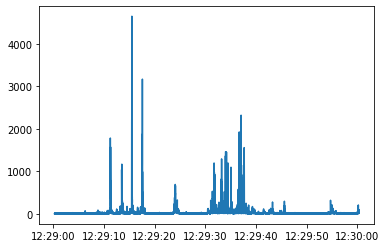

In [28]:
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
print(len(ACC_ex))
plt.plot(ACC_ex['dev_dTime'],ACC_ex['signal'])

In [42]:
# it seems the clocks on the equivitals are nearly 30 s of from the time selected in the cue findings. 
# We can fix this in TimeAlign/Shake_Audio_Cue.ipynb

c = 'cue1_20240309'
cue = CueT[c].copy()
prelim_synch_time = (synch_times[c]+pd.to_timedelta(-10,unit='s')).tz_localize(None)
print(prelim_synch_time)
cue

2024-03-09 12:29:10.294512472


,sTime,peaks,taps,claps
0,-10.000000,0,0.000000e+00,0.0
1,-9.996094,0,0.000000e+00,0.0
2,-9.992188,0,0.000000e+00,0.0
3,-9.988281,0,0.000000e+00,0.0
4,-9.984375,0,0.000000e+00,0.0
...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0
7676,19.984375,0,9.881313e-324,0.0
7677,19.988281,0,9.881313e-324,0.0
7678,19.992188,0,0.000000e+00,0.0


In [43]:
sampleshift_s = cue['sTime'].diff().median()
sf = np.round(1/sampleshift_s)
t_range = [cue['sTime'].iloc[0],cue['sTime'].iloc[-1]]
c_type = 'taps'
xrange = [pd.to_timedelta(t_range[0],unit = 's') + prelim_synch_time,
          pd.to_timedelta(t_range[1],unit = 's') + prelim_synch_time]
sig_sTime = cue['sTime'].values #np.linspace(t_range[0],t_range[1],sf*(t_range[1]-t_range[0]),endpoint=False)
cue.loc[:,'dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time

max_offs = 5
X = al.dt_cut(ACC,'dev_dTime',xrange[0],xrange[1])
sig_t = (X['dev_dTime'].dt.tz_localize(None) - prelim_synch_time.tz_localize(None)).dt.total_seconds()
sig_v = X['signal']
f = interpolate.interp1d(sig_t,sig_v,fill_value='extrapolate')
new_sig = f(sig_sTime)
signal = pd.DataFrame()
signal.loc[:,'signal'] = new_sig
signal.loc[signal['signal'].isna(),'signal'] = 0
# scale signals a little 
M = signal['signal'].quantile(0.998)
signal.loc[:,'signal']  = signal['signal']/M
signal.loc[signal['signal']>1,'signal'] = 1
signal.loc[signal['signal']<0,'signal'] = 0
signal.loc[:,'sTime'] = sig_sTime
signal.loc[:,'dev_dTime'] = pd.to_timedelta(sig_sTime,unit='s')+prelim_synch_time.tz_localize(None)
length = np.min([len(signal),len(cue)]) # they should match, but just in case
# plt.plot(cue['dTime'],cue['taps'])

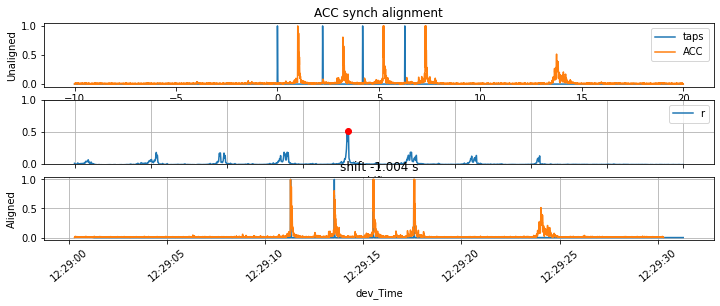

2024-03-09 12:29:11.298418722


In [44]:
xcorred = pd.DataFrame()
max_offs = 10
xcorred['shift_s'] = np.linspace(-max_offs,max_offs,int(2*max_offs*sf), endpoint=False) 
xcorred['r'] = xcov(cue[c_type].iloc[:length], signal['signal'].iloc[:length],int(max_offs*sf))
max_shift = xcorred.loc[xcorred['r'].argmax(),'shift_s']
max_r = xcorred['r'].max()
cue.loc[:,'dev_dTime'] = cue['dTime'] - pd.to_timedelta(max_shift,unit='s')

fig, axes = plt.subplots(3,1,figsize=(12,4))
ax =axes[0]
cue.plot(x='sTime',y=c_type,ax=ax)
signal.plot(x='sTime',y='signal',label='ACC',ax=ax)
ax.set_title('ACC synch alignment')
ax.set_ylabel('Unaligned')
ax.legend()

ax = axes[1]
xcorred.plot(x='shift_s',y='r',ax=ax)
ax.plot(max_shift,max_r,'ro')
ax.set_ylim([0,1])
ax.grid(True)
ax.set_xticklabels('')

ax = axes[2]
ax.plot(cue['dev_dTime'],cue[c_type],label=c_type)
ax.plot(signal['dev_dTime'],signal['signal'],label='ACC')
ax.xaxis.set_tick_params(rotation=40)

ax.grid(True)
ax.set_title('shift '+ str(np.round(max_shift,3))+ ' s')
ax.set_ylabel('Aligned')
ax.set_xlabel('dev_Time')
plt.show()

cue_time = cue.loc[cue['peaks']==1,'dev_dTime'].iloc[0].tz_localize(None) 
C_results = {'best': cue_time,'CCC':xcorred,'cue':cue,'signal':signal}
print(cue_time)

In [45]:
synch_times[c]

Timestamp('2024-03-09 12:29:20.294512472')

In [46]:
ACC.iloc[-5:,:]

,dev_dTime,signal
4028734,2024-03-09 16:49:01.261,18.138357
4028735,2024-03-09 16:49:01.265,9.797959
4028736,2024-03-09 16:49:01.269,8.062258
4028737,2024-03-09 16:49:01.273,8.000000
4028738,2024-03-09 16:49:01.277,8.062258


In [47]:
dt_0 

Timestamp('2024-03-09 16:42:51.326464853')

In [48]:
CueT[c]

,sTime,peaks,taps,claps
0,-10.000000,0,0.000000e+00,0.0
1,-9.996094,0,0.000000e+00,0.0
2,-9.992188,0,0.000000e+00,0.0
3,-9.988281,0,0.000000e+00,0.0
4,-9.984375,0,0.000000e+00,0.0
...,...,...,...,...
7675,19.980469,0,9.881313e-324,0.0
7676,19.984375,0,9.881313e-324,0.0
7677,19.988281,0,9.881313e-324,0.0
7678,19.992188,0,0.000000e+00,0.0


In [49]:
synch_times['cue2_20240309']

Timestamp('2024-03-09 16:43:11.326464853')

In [50]:
ACC_ex

,dev_dTime,signal
3934031,2024-03-09 16:42:51.328,5.656854
3934032,2024-03-09 16:42:51.331,11.357817
3934033,2024-03-09 16:42:51.335,15.000000
3934034,2024-03-09 16:42:51.339,20.639767
3934035,2024-03-09 16:42:51.343,16.970563
...,...,...
3949386,2024-03-09 16:43:51.308,7.615773
3949387,2024-03-09 16:43:51.312,11.357817
3949388,2024-03-09 16:43:51.316,20.469489
3949389,2024-03-09 16:43:51.320,11.401754


In [51]:
c = 'cue2_20240309'
dt_0 = synch_times[c]-pd.to_timedelta(20,unit='s')
dt_1 = synch_times[c]+pd.to_timedelta(40,unit='s')
ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
ACC_ex

,dev_dTime,signal
3934031,2024-03-09 16:42:51.328,5.656854
3934032,2024-03-09 16:42:51.331,11.357817
3934033,2024-03-09 16:42:51.335,15.000000
3934034,2024-03-09 16:42:51.339,20.639767
3934035,2024-03-09 16:42:51.343,16.970563
...,...,...
3949386,2024-03-09 16:43:51.308,7.615773
3949387,2024-03-09 16:43:51.312,11.357817
3949388,2024-03-09 16:43:51.316,20.469489
3949389,2024-03-09 16:43:51.320,11.401754


In [52]:
CueT[c]

,sTime,peaks,taps,claps
0,15221.032000,0,0.000000e+00,0.0
1,15221.035906,0,0.000000e+00,0.0
2,15221.039812,0,0.000000e+00,0.0
3,15221.043719,0,0.000000e+00,0.0
4,15221.047625,0,0.000000e+00,0.0
...,...,...,...,...
7675,15251.012469,0,9.881313e-324,0.0
7676,15251.016375,0,9.881313e-324,0.0
7677,15251.020281,0,9.881313e-324,0.0
7678,15251.024187,0,0.000000e+00,0.0


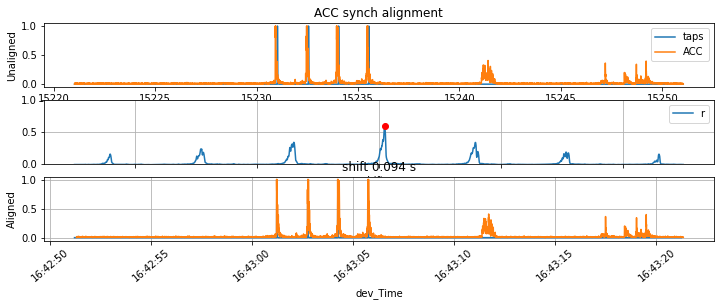

Timestamp('2024-03-09 16:43:01.232762472')

In [53]:
c = 'cue2_20240309'
results = min_align(ACC,CueT[c].copy(),prelim_synch_time,10)
results['best_dt']

# Running through the sensors

In [56]:
data_dir='/Volumes/Seagatehub/BiC2024/20240309/Equivital/Extracted SEM Data/'
sep = '/'
projectName=''
df_datafiles = qex.qiosk_recordings(data_dir,projectName,sep)
df_datafiles.set_index('DevName',inplace=True)
df_datafiles.iloc[:5,:]


,Signal,ID,Date,Session,FileName,FileType,FileSize,RecStart,RecEnd,Duration,...,SubjectNames,SENSOR ID,SUBJECT ID,SUBJECT AGE,HR(BPM),HRC(%),BELT OFF,LEAD OFF,MOTION,BODY POSITION
DevName,,,,,,,,,,,,,,,,,,,,,
AU814,DATA,5022151,240309,0,DATA-AU814-5022151-24030900.CSV,csv,92568,2024-03-09 12:19:38+00:00,2024-03-09 16:55:53+00:00,16575.0,...,[AU814],5022151.0,AU814,53.0,0,100.0,0.0,1.0,Stationary,Side
AU815,DATA,5022009,240309,0,DATA-AU815-5022009-24030900.CSV,csv,92383,2024-03-09 12:19:39+00:00,2024-03-09 16:56:09+00:00,16590.0,...,[AU815],5022009.0,AU815,53.0,0,100.0,1.0,1.0,Stationary,Side
AU818,DATA,5022141,240309,0,DATA-AU818-5022141-24030900.CSV,csv,90182,2024-03-09 12:19:41+00:00,2024-03-09 16:49:41+00:00,16200.0,...,[AU818],5022141.0,AU818,53.0,2,100.0,0.0,1.0,Stationary,Side
AU819,DATA,5022006,240309,0,DATA-AU819-5022006-24030900.CSV,csv,92167,2024-03-09 12:19:42+00:00,2024-03-09 16:56:12+00:00,16590.0,...,[AU819],5022006.0,AU819,53.0,0,100.0,1.0,1.0,Stationary,Side
AU820,DATA,5023926,240309,0,DATA-AU820-5023926-24030900.CSV,csv,90082,2024-03-09 12:19:43+00:00,2024-03-09 16:49:43+00:00,16200.0,...,[AU820],5023926.0,AU820,53.0,0,100.0,1.0,1.0,Stationary,Side


['AU814', 15.331808090209961]


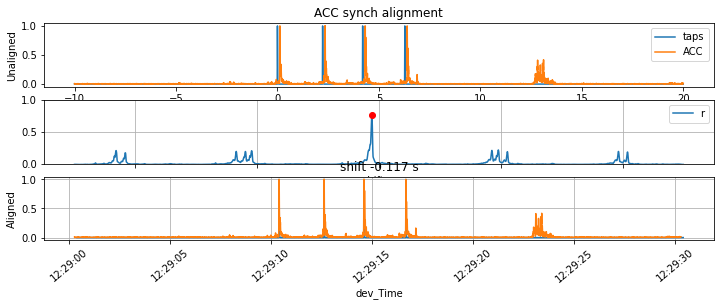

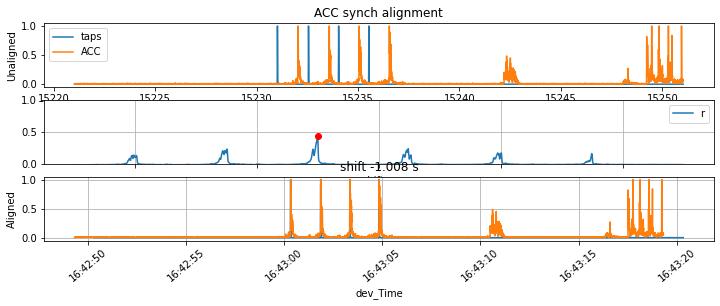

['AU815', 34.04021096229553]


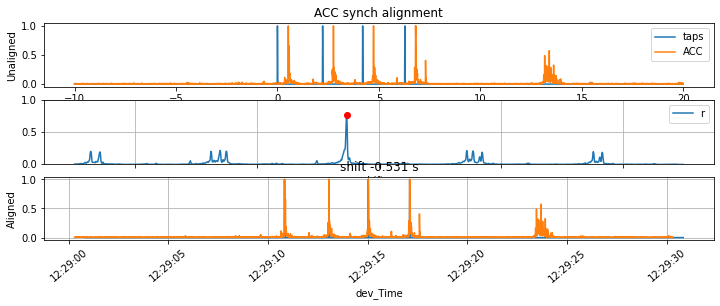

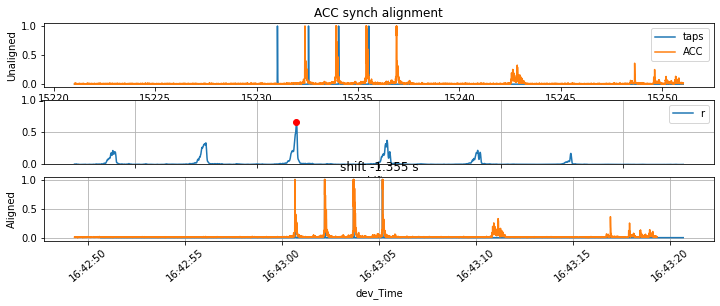

['AU818', 51.28179407119751]


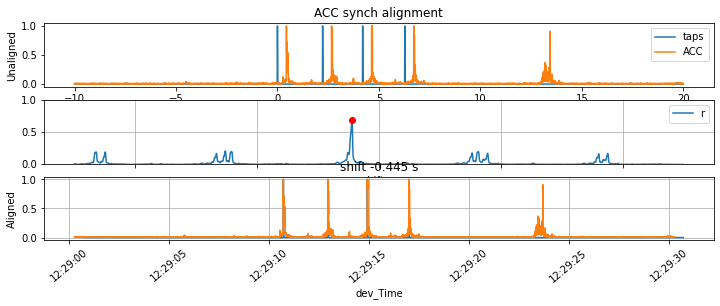

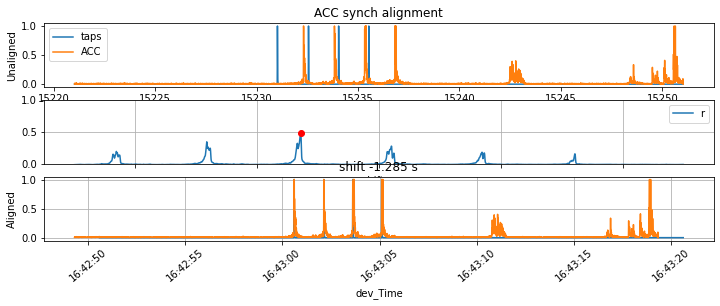

['AU819', 69.7884681224823]


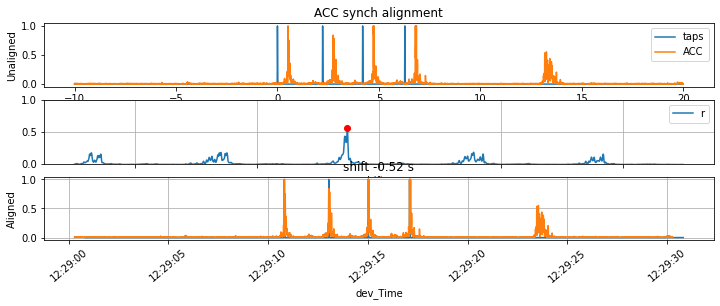

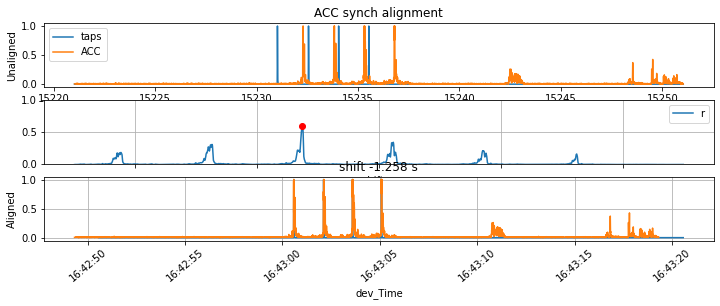

['AU820', 87.20130515098572]


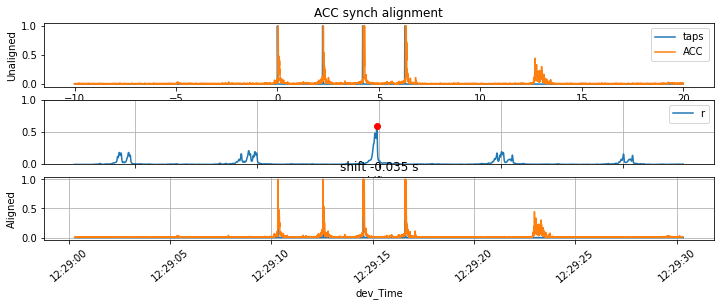

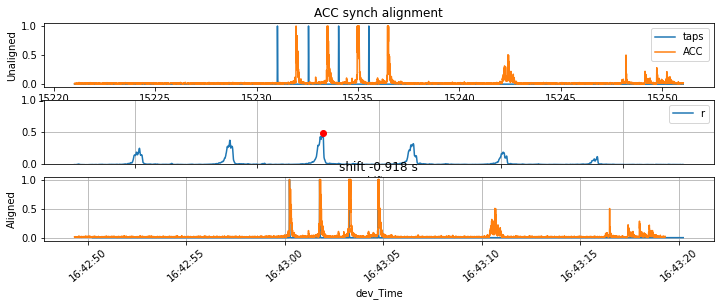

['AU816', 105.18861603736877]


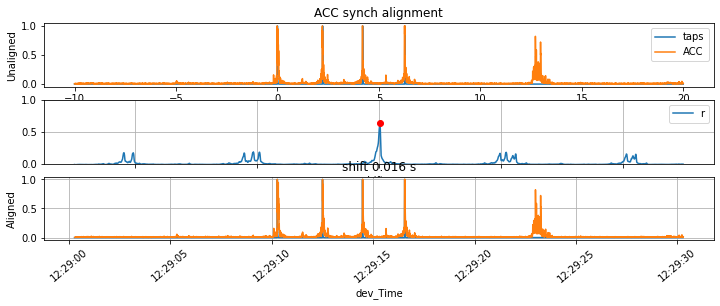

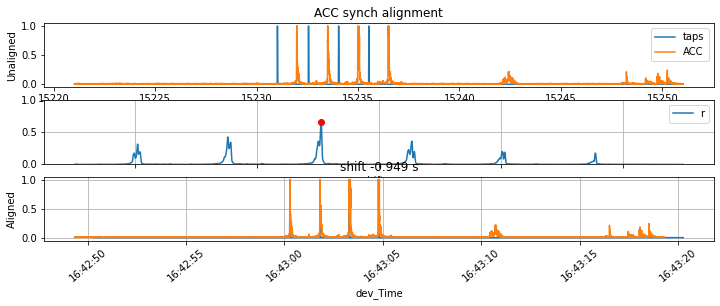

['AU817', 122.05682110786438]


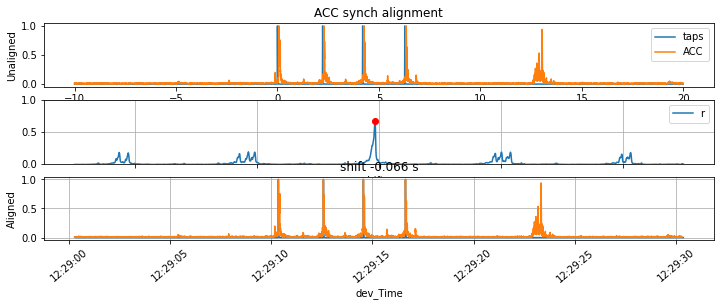

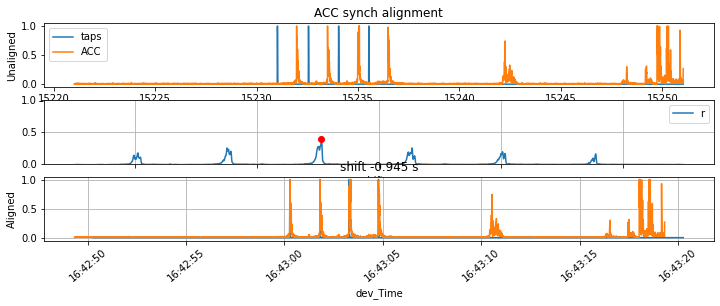

['AU812', 139.59943199157715]


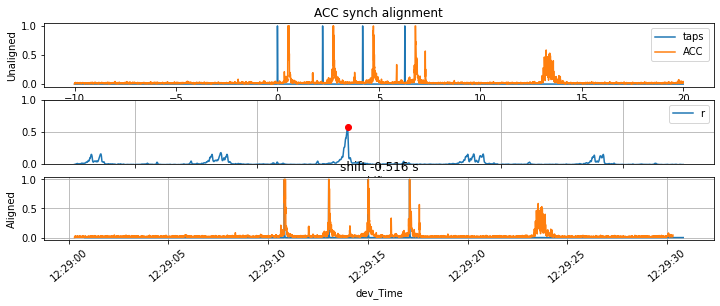

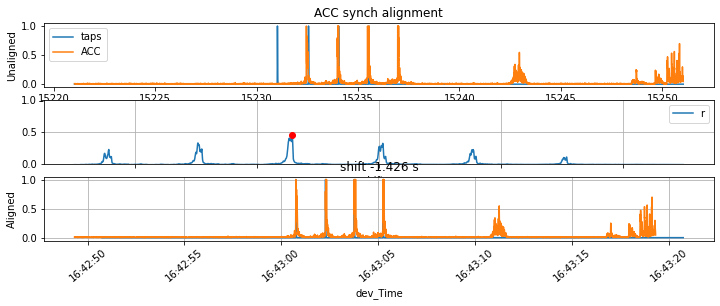

['AU813', 156.94911432266235]


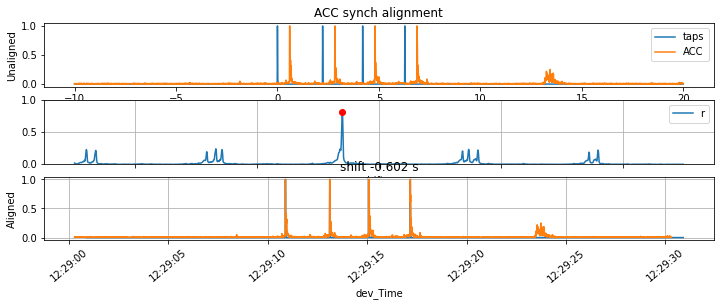

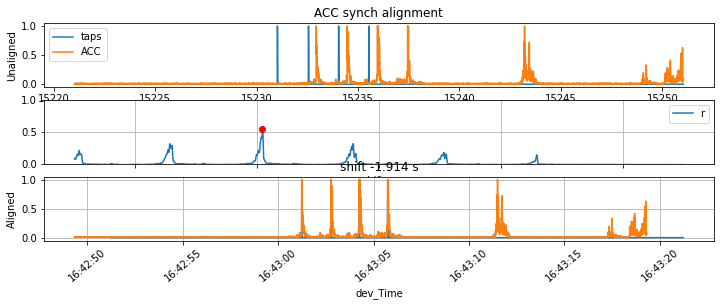

['VN110', 174.29864192008972]


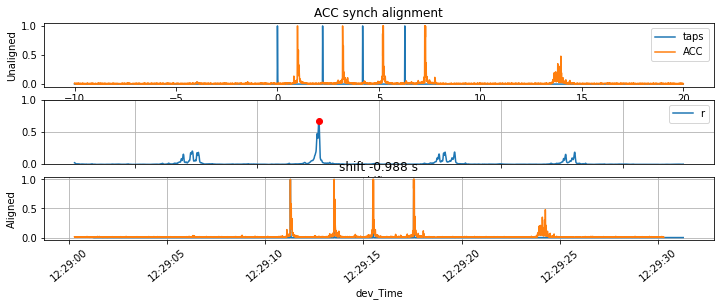

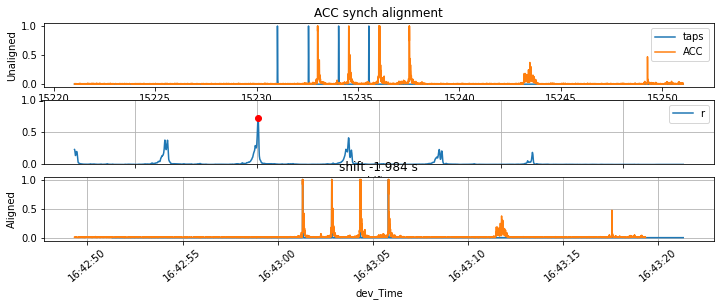

['PC702', 191.5719449520111]


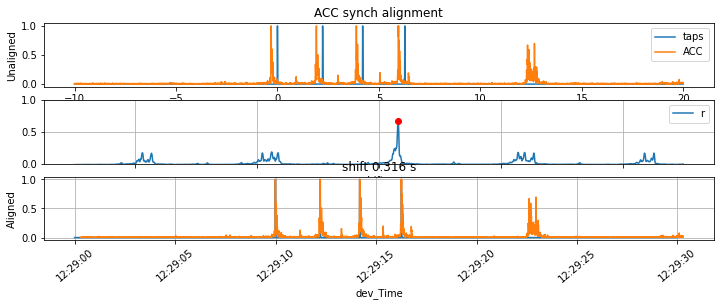

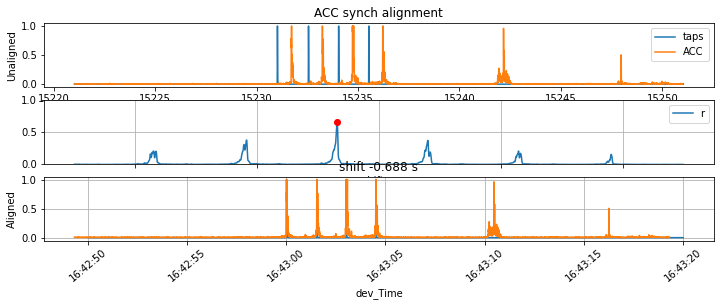

['BR609', 209.9926679134369]


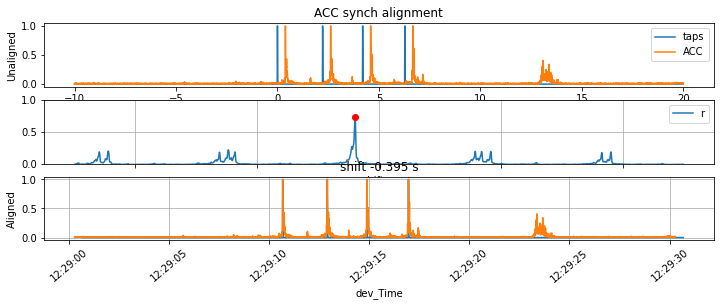

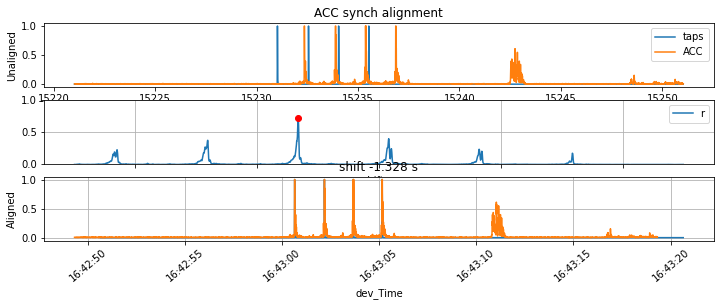

['VN111', 228.30207800865173]


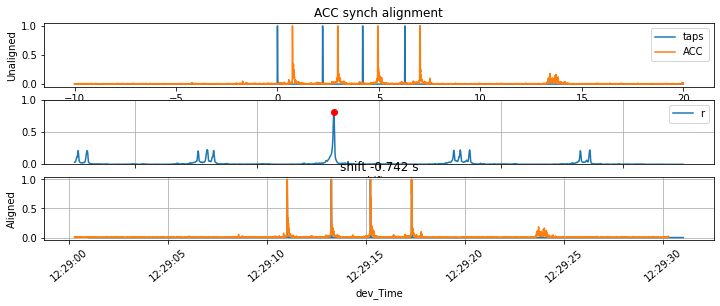

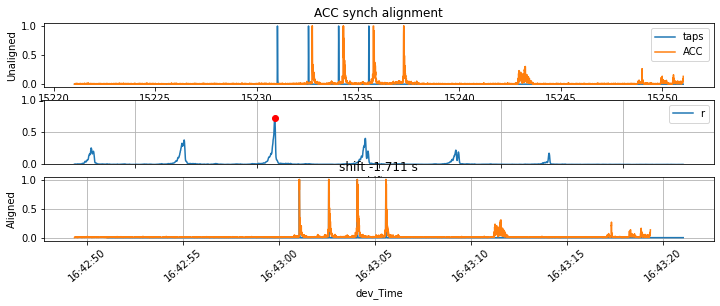

['VN212', 245.7048089504242]


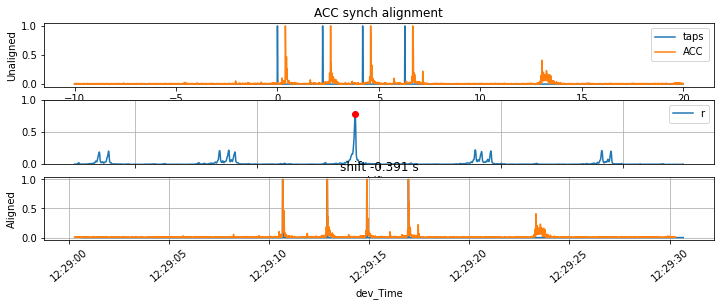

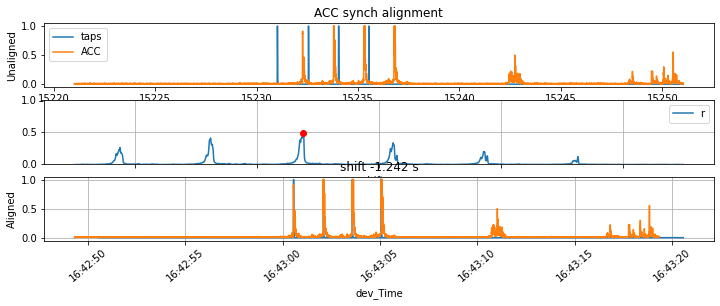

['VN104', 263.49277329444885]


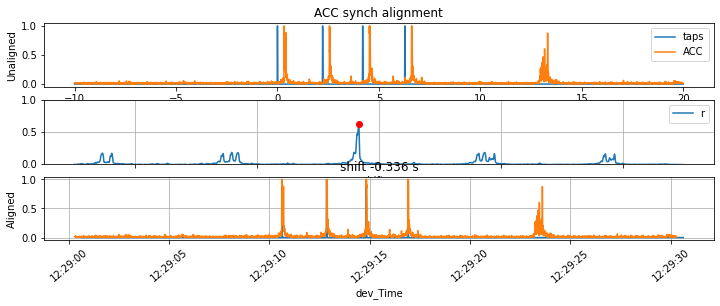

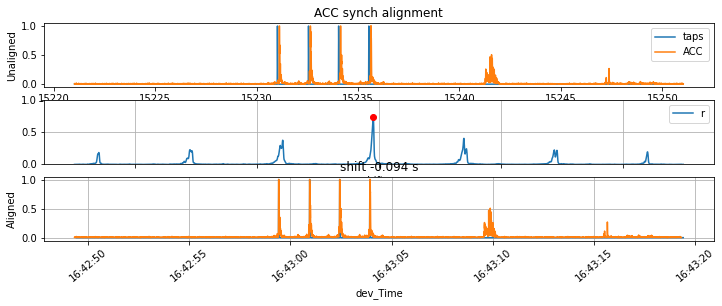

['VN101', 281.13801407814026]


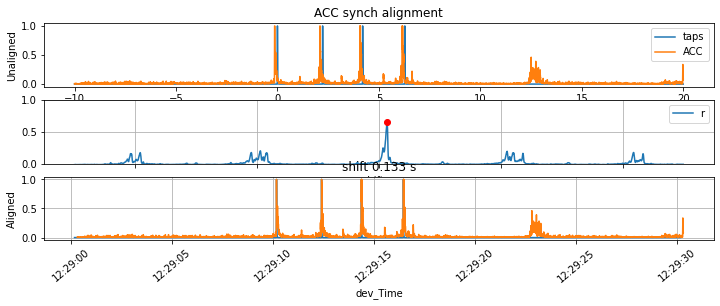

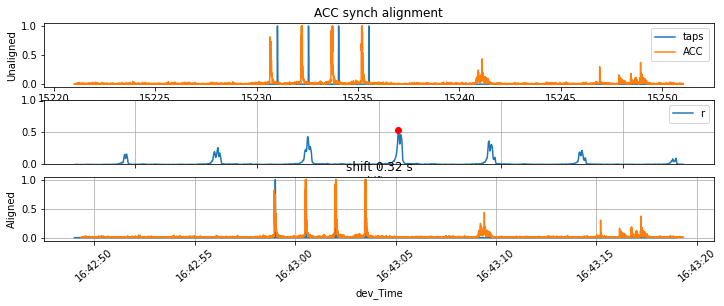

['BR604', 298.04234194755554]


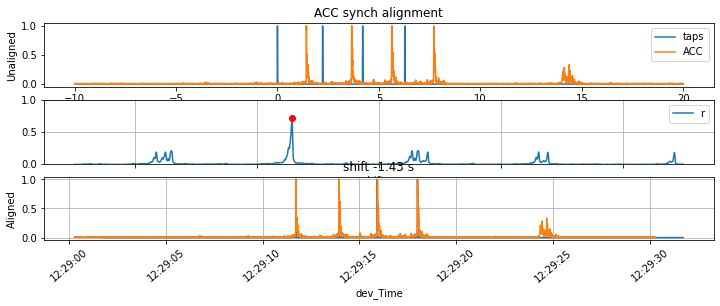

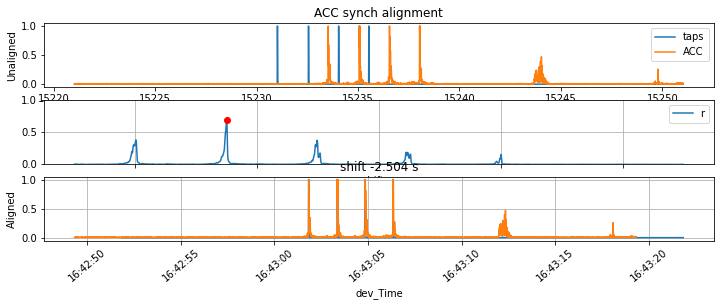

['LS407', 315.3684802055359]


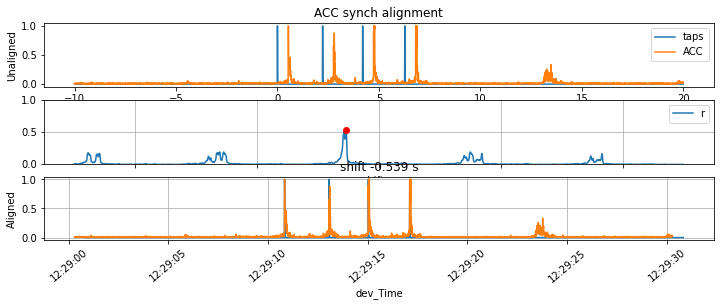

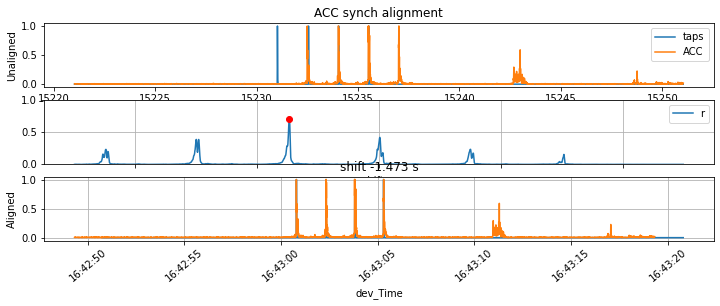

['LS401', 332.2564322948456]


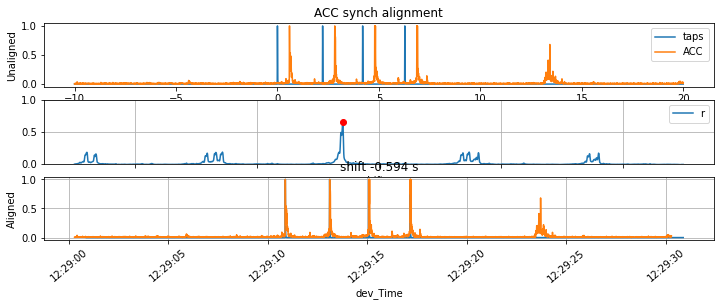

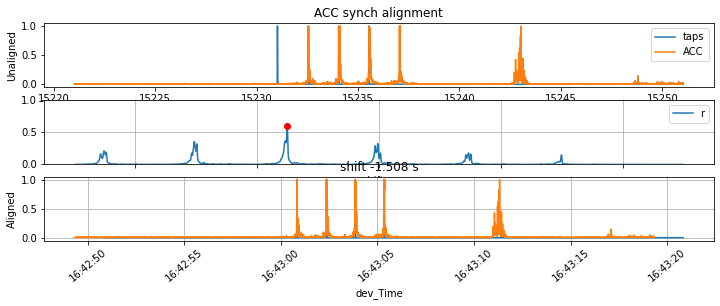

['BR606', 349.69431614875793]


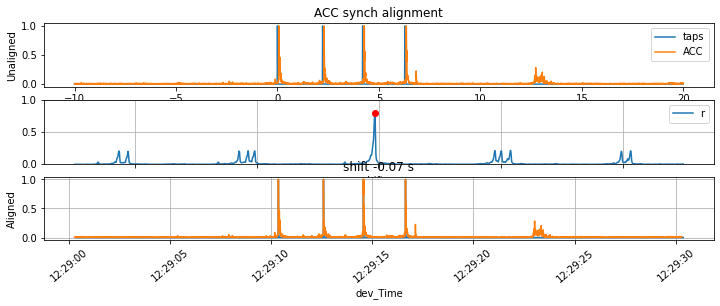

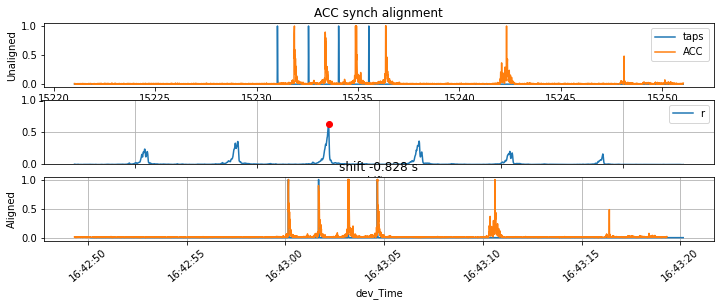

['VN105', 366.83465600013733]


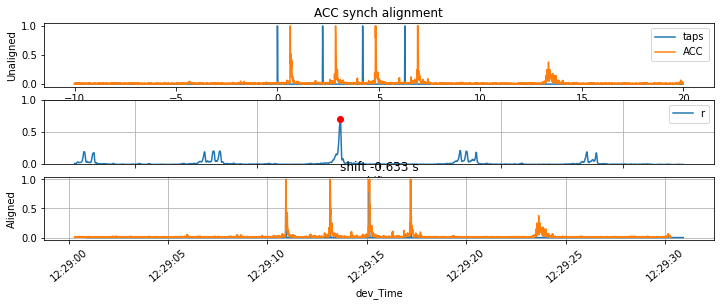

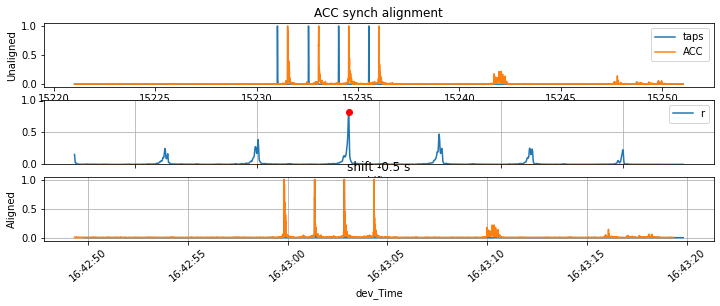

['WW506', 383.8645281791687]


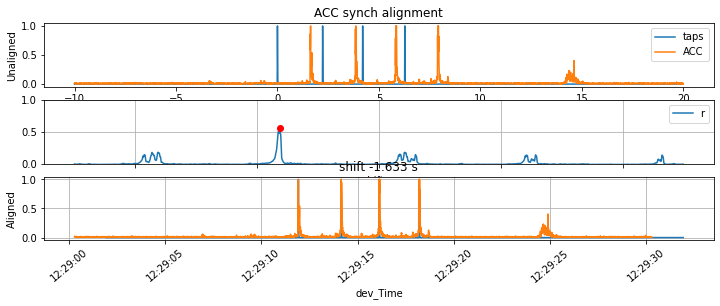

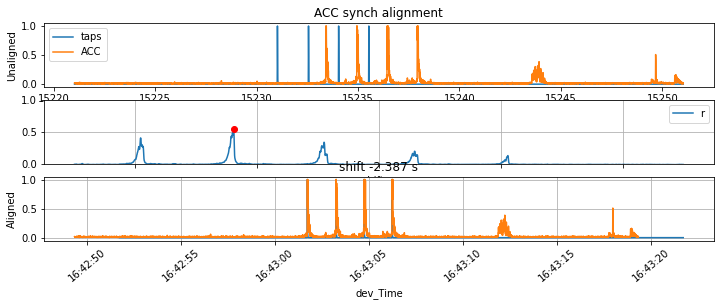

['BR608', 401.00719118118286]


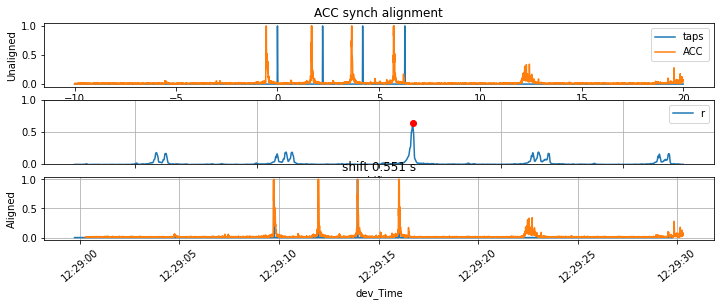

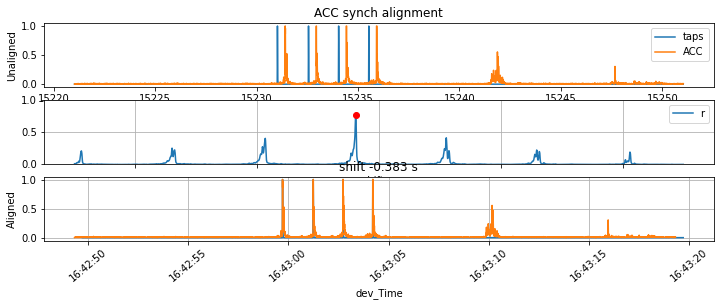

['VA305', 418.1573100090027]


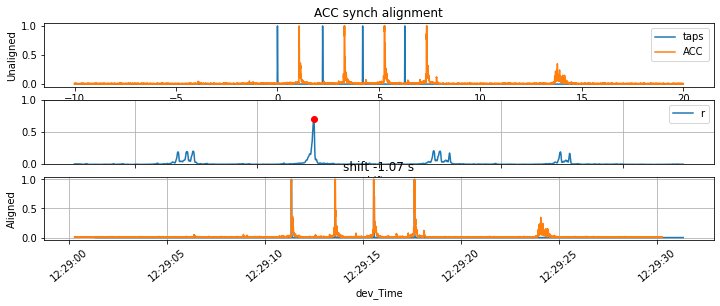

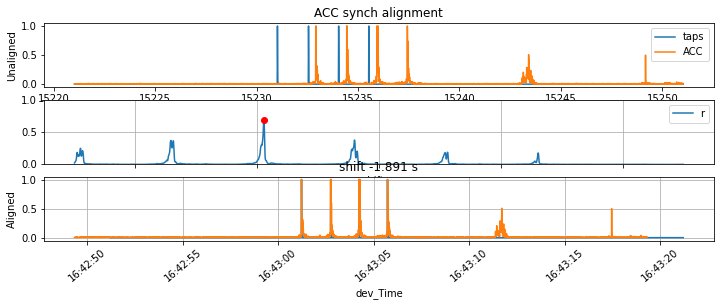

['PC709', 435.70866799354553]


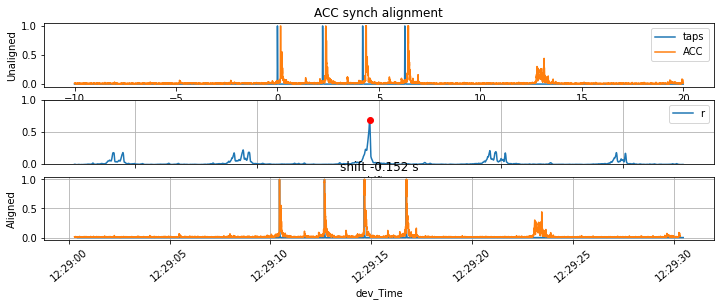

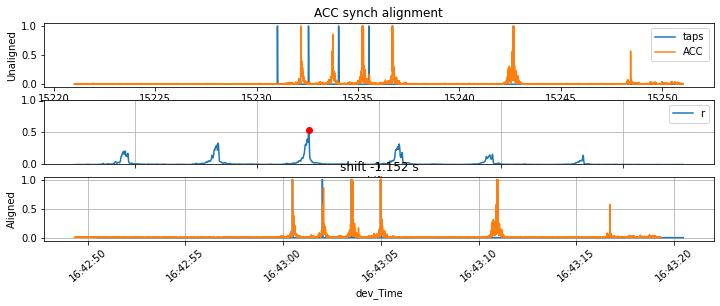

['VN206', 452.8271732330322]


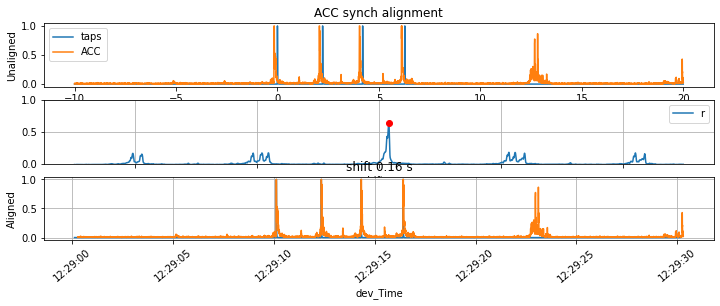

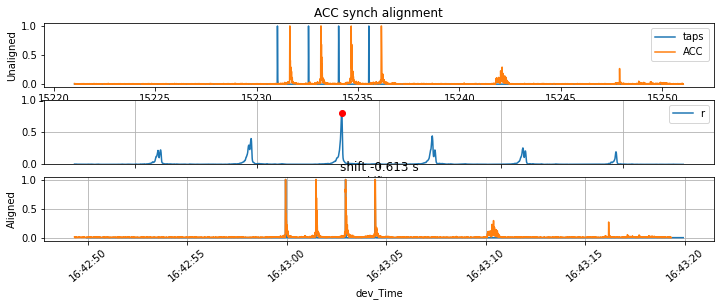

['LS410', 469.83272409439087]


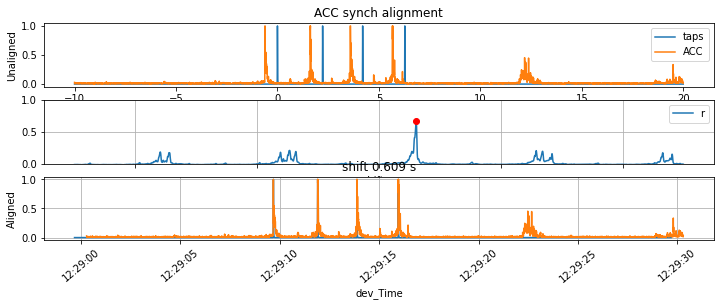

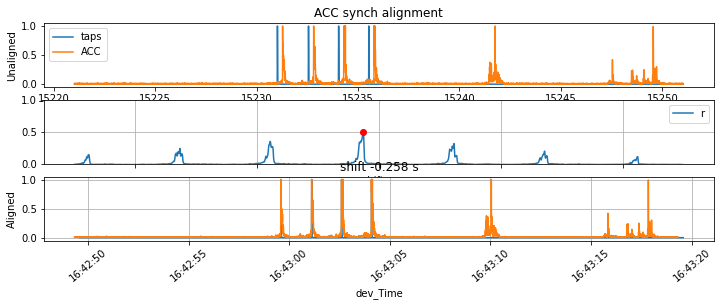

['WW508', 486.658411026001]


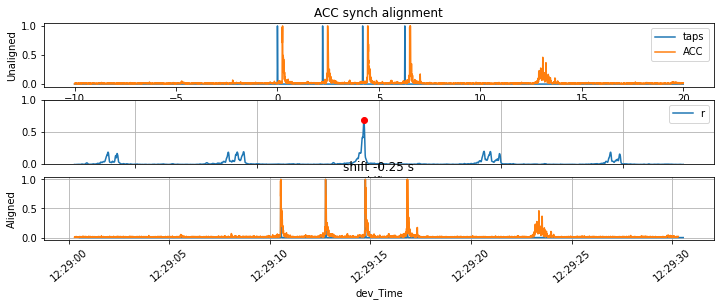

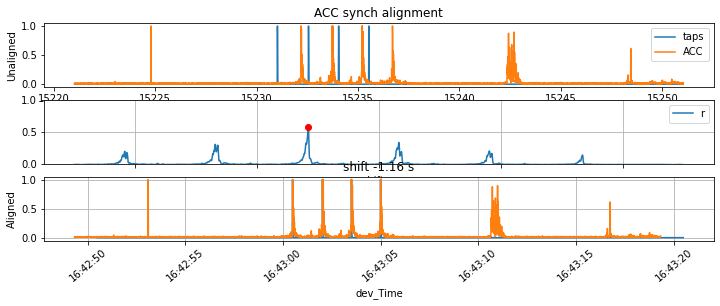

['VN211', 504.63078927993774]


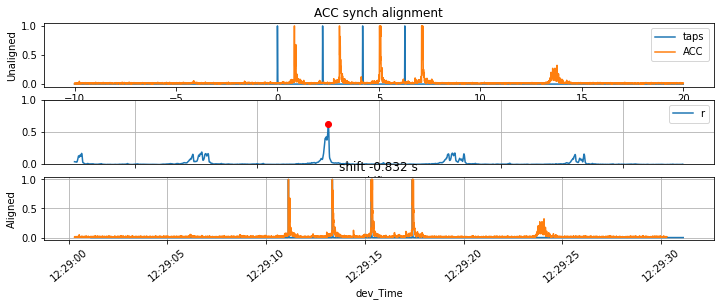

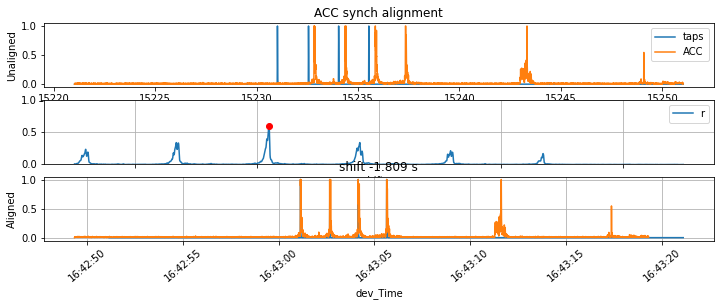

['VA304', 521.9598789215088]


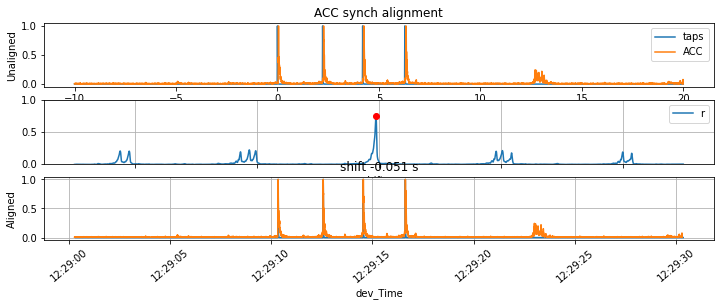

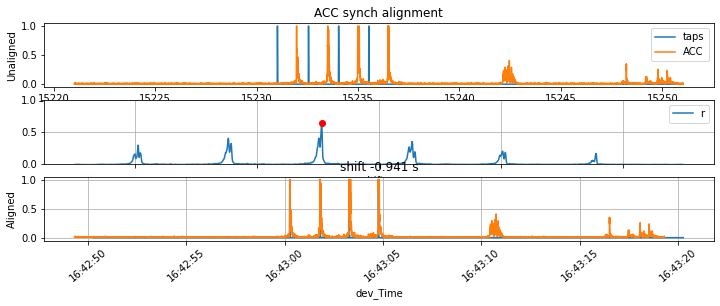

['VA309', 539.2860119342804]


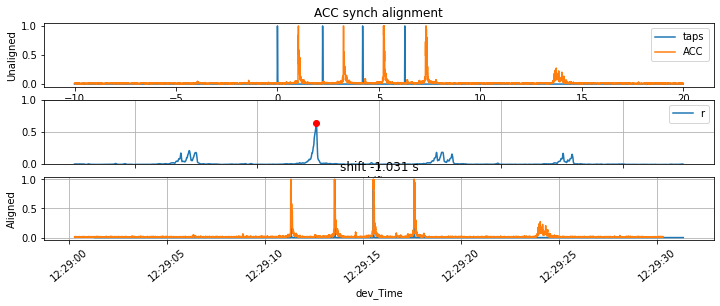

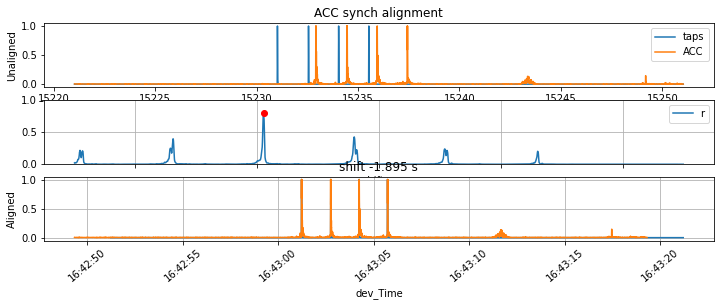

['LS409', 557.1935970783234]


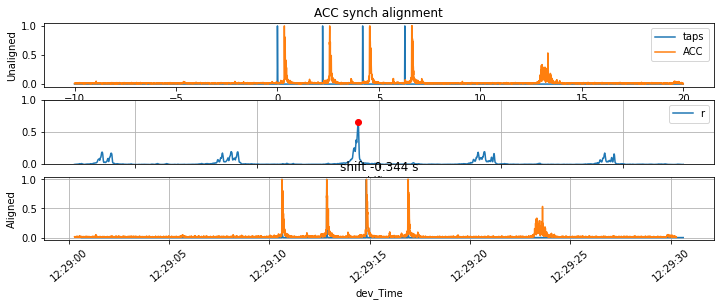

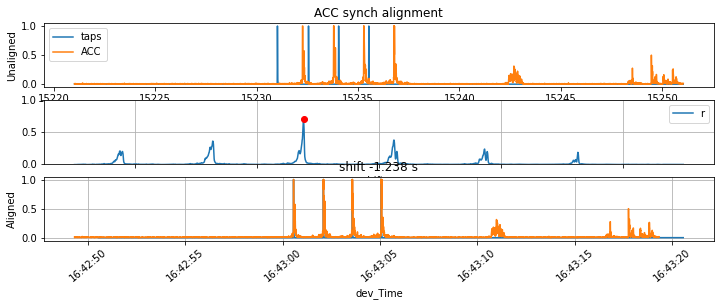

['LS404', 574.5316622257233]


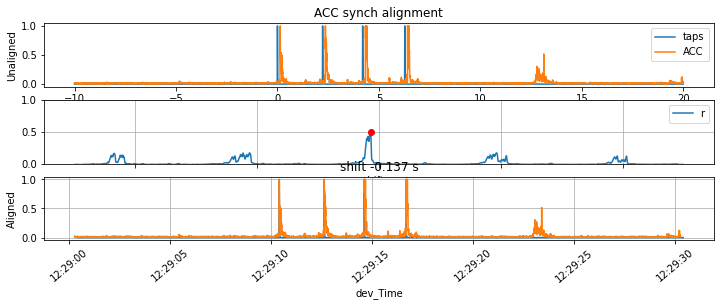

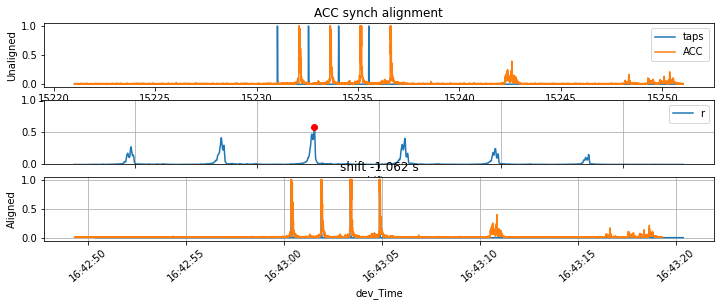

['VN201', 591.2733099460602]


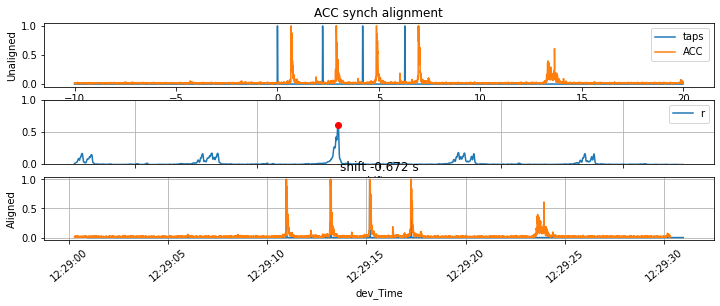

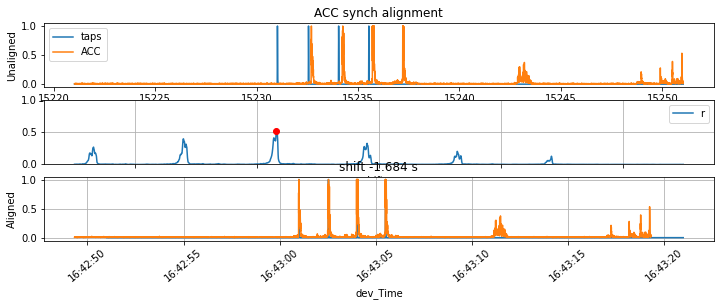

['VN109', 608.2077081203461]


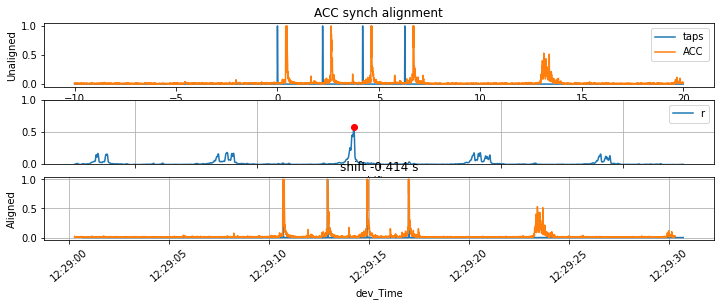

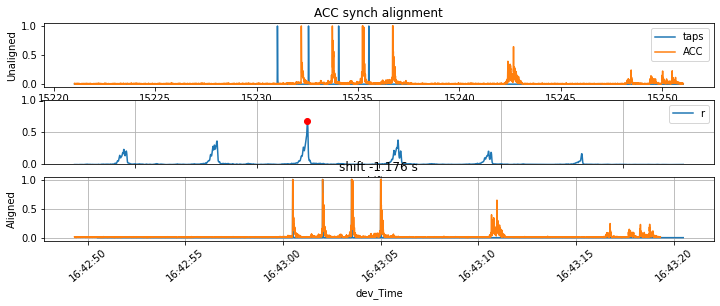

['WW507', 626.0403101444244]


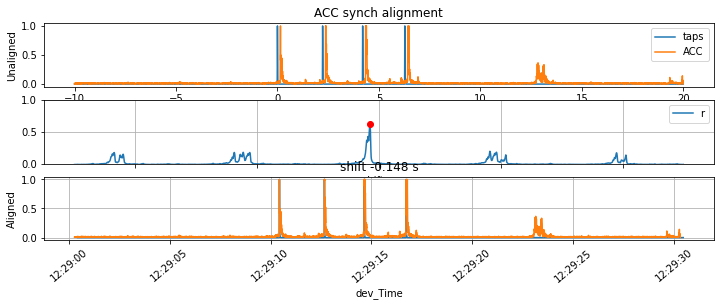

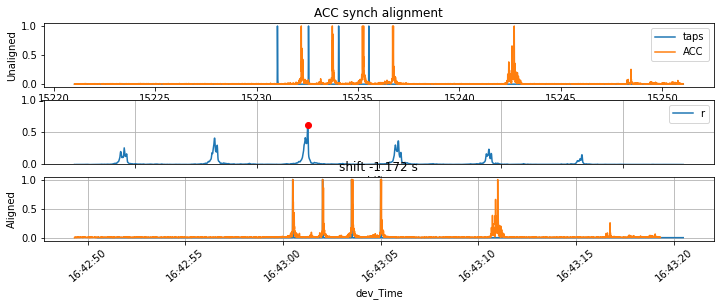

['PC710', 644.3322870731354]


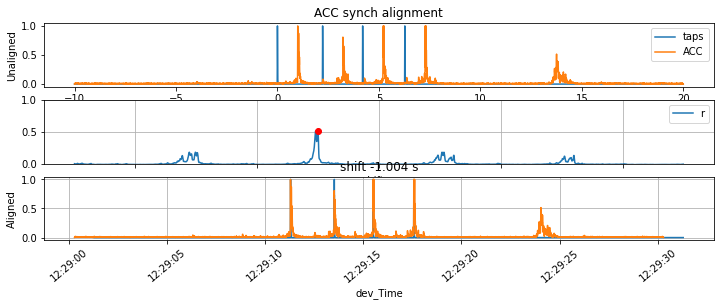

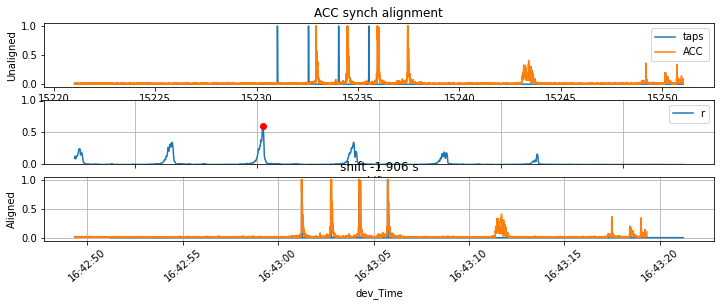

['LS405', 662.7165949344635]


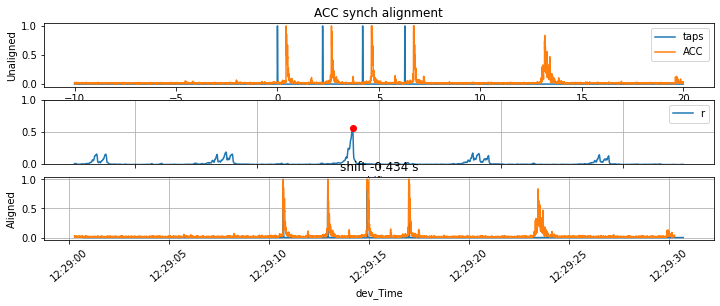

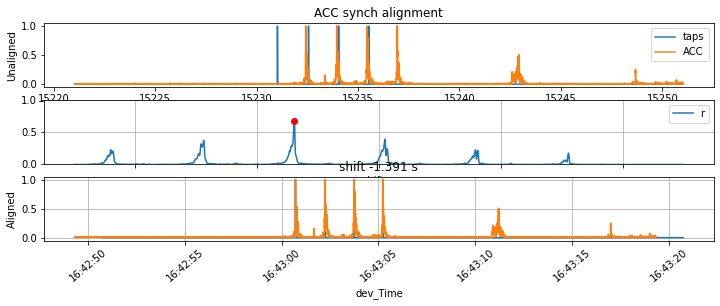

['BR605', 681.1514551639557]


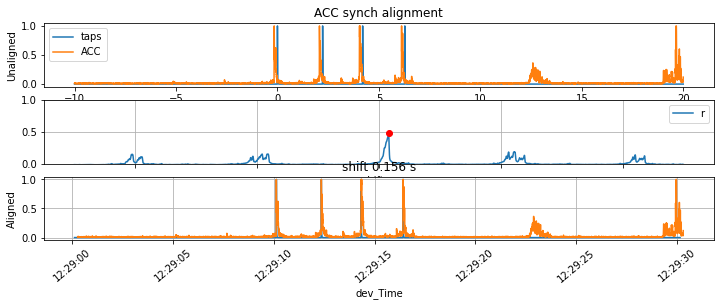

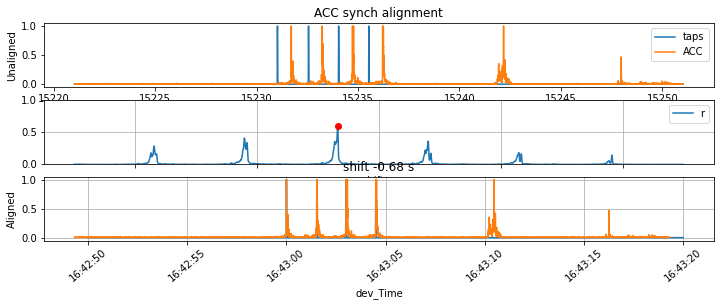

['WW504', 698.8673832416534]


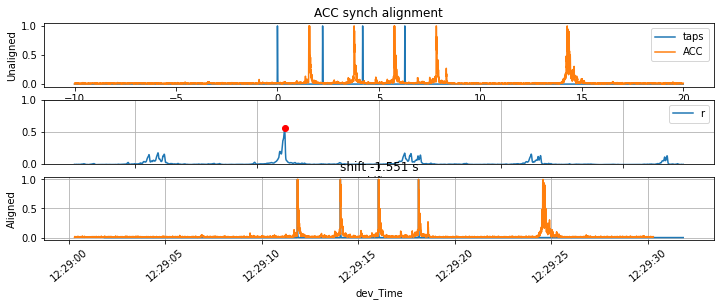

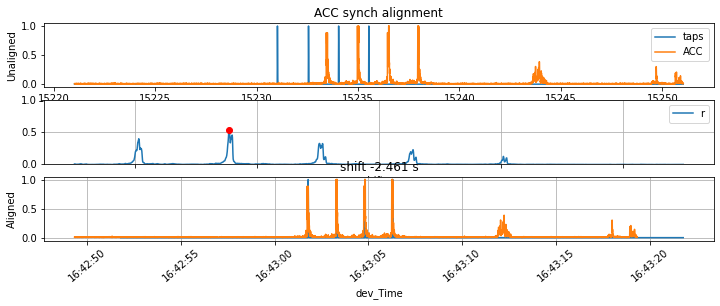

701.120108127594


,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r
DevName,,,,,,
AU814,2024-03-09 12:29:10.411699972,-0.117188,0.755044,2024-03-09 16:43:00.334324972,0.992188,0.438914
AU815,2024-03-09 12:29:10.825762472,-0.53125,0.755243,2024-03-09 16:43:00.681981222,0.644531,0.657394
AU818,2024-03-09 12:29:10.739824972,-0.445312,0.685556,2024-03-09 16:43:00.611668722,0.714844,0.486087
AU819,2024-03-09 12:29:10.814043722,-0.519531,0.561867,2024-03-09 16:43:00.584324972,0.742188,0.597215
AU820,2024-03-09 12:29:10.329668722,-0.035156,0.591183,2024-03-09 16:43:00.244481222,1.082031,0.487207
AU816,2024-03-09 12:29:10.278887472,0.015625,0.635232,2024-03-09 16:43:00.275731222,1.050781,0.66104
AU817,2024-03-09 12:29:10.360918722,-0.066406,0.667776,2024-03-09 16:43:00.271824972,1.054688,0.391168
AU812,2024-03-09 12:29:10.810137472,-0.515625,0.571462,2024-03-09 16:43:00.752293722,0.574219,0.444856
AU813,2024-03-09 12:29:10.896074972,-0.601562,0.80939,2024-03-09 16:43:01.240574972,0.085938,0.541085


In [57]:
df_shifts = pd.DataFrame(index = df_datafiles.index,columns = ['Cue1_devdTime','Cue1_s','Cue1_r','Cue2_devdTime','Cue2_s','Cue2_r'])
tic = time.time()
t_center = -10
t_drift = 2

for pid,row in df_datafiles.iterrows():
    V = pd.read_csv(df_datafiles.loc[pid,'ACCloc'],skipinitialspace=True)
    ACC = pd.DataFrame()
    ACC['dev_dTime'] = pd.to_datetime(V['DateTime'])
    df = V.loc[:,[ 'Vert Accelerometer','Lat Accelerometer','Long Accelerometer']]
    ACC['signal'] = np.sqrt(np.square(df.diff()).sum(axis=1))
    ACC = remove_tz_from_dataframe(ACC)
    print([pid,time.time()-tic])

    dt_0 = synch_times['cue1_20240309']-pd.to_timedelta(25,unit='s')
    dt_1 = synch_times['cue1_20240309']+pd.to_timedelta(25,unit='s')
    ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
    maxlag_s = 5
    results = min_align(ACC_ex,CueT['cue1_20240309'].copy(),(synch_times['cue1_20240309']+pd.to_timedelta(t_center,unit='s')).tz_localize(None),maxlag_s)
    df_shifts.loc[pid,'Cue1_devdTime'] = results['best_dt']
    df_shifts.loc[pid,'Cue1_s'] = results['best_s']
    df_shifts.loc[pid,'Cue1_r'] = results['best_r']

    dt_0 = synch_times['cue2_20240309']-pd.to_timedelta(25,unit='s')
    dt_1 = synch_times['cue2_20240309']+pd.to_timedelta(25,unit='s')
    ACC_ex = al.dt_cut(ACC,'dev_dTime',dt_0,dt_1)
    maxlag_s = 10
    results = min_align(ACC_ex,CueT['cue2_20240309'].copy(),(synch_times['cue1_20240309']+pd.to_timedelta(t_center-t_drift,unit='s')).tz_localize(None),maxlag_s)
    df_shifts.loc[pid,'Cue2_devdTime'] = results['best_dt']
    df_shifts.loc[pid,'Cue2_s'] = results['best_s']+t_drift
    df_shifts.loc[pid,'Cue2_r'] = results['best_r']
    
print(time.time()-tic)
df_shifts

In [63]:
[df_shifts['Cue1_s'].mean(),df_shifts['Cue2_s'].mean()]

[-0.41826171875, 0.75361328125]

In [64]:
df_shifts['dur_dt']=pd.to_datetime(df_shifts['Cue2_devdTime'])-pd.to_datetime(df_shifts['Cue1_devdTime'])
df_shifts['dur_s']=df_shifts['dur_dt'].dt.total_seconds() #pd.to_datetime(cue_times['DateTime'],format='ISO8601')

In [65]:
(synch_times['cue2_20240309']-synch_times['cue1_20240309']).total_seconds()

15231.031952

In [66]:
df_shifts['devID'] = df_datafiles['ID']

In [67]:
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID
DevName,,,,,,,,,
AU814,2024-03-09 12:29:10.411699972,-0.117188,0.755044,2024-03-09 16:43:00.334324972,0.992188,0.438914,0 days 04:13:49.922625,15229.922625,5022151
AU815,2024-03-09 12:29:10.825762472,-0.53125,0.755243,2024-03-09 16:43:00.681981222,0.644531,0.657394,0 days 04:13:49.856218750,15229.856219,5022009
AU818,2024-03-09 12:29:10.739824972,-0.445312,0.685556,2024-03-09 16:43:00.611668722,0.714844,0.486087,0 days 04:13:49.871843750,15229.871844,5022141
AU819,2024-03-09 12:29:10.814043722,-0.519531,0.561867,2024-03-09 16:43:00.584324972,0.742188,0.597215,0 days 04:13:49.770281250,15229.770281,5022006
AU820,2024-03-09 12:29:10.329668722,-0.035156,0.591183,2024-03-09 16:43:00.244481222,1.082031,0.487207,0 days 04:13:49.914812500,15229.914812,5023926
AU816,2024-03-09 12:29:10.278887472,0.015625,0.635232,2024-03-09 16:43:00.275731222,1.050781,0.66104,0 days 04:13:49.996843750,15229.996844,5022156
AU817,2024-03-09 12:29:10.360918722,-0.066406,0.667776,2024-03-09 16:43:00.271824972,1.054688,0.391168,0 days 04:13:49.910906250,15229.910906,5022073
AU812,2024-03-09 12:29:10.810137472,-0.515625,0.571462,2024-03-09 16:43:00.752293722,0.574219,0.444856,0 days 04:13:49.942156250,15229.942156,5022241
AU813,2024-03-09 12:29:10.896074972,-0.601562,0.80939,2024-03-09 16:43:01.240574972,0.085938,0.541085,0 days 04:13:50.344500,15230.344500,5022244


In [68]:
cues_delta = (synch_times['cue2_20240309']-synch_times['cue1_20240309']).total_seconds()
df_shifts['drift_s'] = df_shifts['dur_s']-cues_delta 
df_shifts['drift_rate_sphr']=(df_shifts['drift_s'])/(cues_delta/3600)
# drifted seconds per hour
df_shifts['drift_rate_sphr']

DevName
AU814   -0.262200
AU815   -0.277896
AU818   -0.274203
AU819   -0.298208
AU820   -0.264047
AU816   -0.244658
AU817   -0.264970
AU812   -0.257584
AU813   -0.162486
VN110   -0.237271
PC702   -0.235425
BR609   -0.252044
VN111   -0.243734
VN212   -0.271433
VN104   -0.529951
VN101   -0.517025
BR604   -0.218806
LS407   -0.252044
LS401   -0.256660
BR606   -0.293592
VN105   -0.504099
WW506   -0.294515
BR608   -0.252044
VA305   -0.278819
PC709   -0.236348
VN206   -0.289898
LS410   -0.267740
WW508   -0.257584
VN211   -0.241888
VA304   -0.262200
VA309   -0.268663
LS409   -0.261277
LS404   -0.253891
VN201   -0.233578
VN109   -0.292668
WW507   -0.230809
PC710   -0.259430
LS405   -0.246504
BR605   -0.275126
WW504   -0.257584
Name: drift_rate_sphr, dtype: float64

In [71]:
df_shifts['devID'] = df_datafiles['ID']
df_shifts['ACCFile'] = df_datafiles['ACCloc']
df_shifts['Cue1_file'] = './outfiles/cue1_20240309.csv'
df_shifts['Cue1_name'] = 'cue1_20240309'
df_shifts['Cue1_dt'] = synch_times['cue1_20240309']
df_shifts['Cue2_file'] = './outfiles/cue2_20240309.csv'
df_shifts['Cue2_name'] = 'cue2_20240309'
df_shifts['Cue2_dt'] = synch_times['cue2_20240309']
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU814,2024-03-09 12:29:10.411699972,-0.117188,0.755044,2024-03-09 16:43:00.334324972,0.992188,0.438914,0 days 04:13:49.922625,15229.922625,5022151,-1.109327,-0.262200,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU815,2024-03-09 12:29:10.825762472,-0.53125,0.755243,2024-03-09 16:43:00.681981222,0.644531,0.657394,0 days 04:13:49.856218750,15229.856219,5022009,-1.175733,-0.277896,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU818,2024-03-09 12:29:10.739824972,-0.445312,0.685556,2024-03-09 16:43:00.611668722,0.714844,0.486087,0 days 04:13:49.871843750,15229.871844,5022141,-1.160108,-0.274203,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU819,2024-03-09 12:29:10.814043722,-0.519531,0.561867,2024-03-09 16:43:00.584324972,0.742188,0.597215,0 days 04:13:49.770281250,15229.770281,5022006,-1.261671,-0.298208,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU820,2024-03-09 12:29:10.329668722,-0.035156,0.591183,2024-03-09 16:43:00.244481222,1.082031,0.487207,0 days 04:13:49.914812500,15229.914812,5023926,-1.117140,-0.264047,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU816,2024-03-09 12:29:10.278887472,0.015625,0.635232,2024-03-09 16:43:00.275731222,1.050781,0.66104,0 days 04:13:49.996843750,15229.996844,5022156,-1.035108,-0.244658,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU817,2024-03-09 12:29:10.360918722,-0.066406,0.667776,2024-03-09 16:43:00.271824972,1.054688,0.391168,0 days 04:13:49.910906250,15229.910906,5022073,-1.121046,-0.264970,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU812,2024-03-09 12:29:10.810137472,-0.515625,0.571462,2024-03-09 16:43:00.752293722,0.574219,0.444856,0 days 04:13:49.942156250,15229.942156,5022241,-1.089796,-0.257584,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU813,2024-03-09 12:29:10.896074972,-0.601562,0.80939,2024-03-09 16:43:01.240574972,0.085938,0.541085,0 days 04:13:50.344500,15230.344500,5022244,-0.687452,-0.162486,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853


In [72]:
df_shifts.to_csv('./outfiles/Cue_dev_align_20240309.csv')
df_shifts

,Cue1_devdTime,Cue1_s,Cue1_r,Cue2_devdTime,Cue2_s,Cue2_r,dur_dt,dur_s,devID,drift_s,drift_rate_sphr,ACCFile,Cue1_file,Cue1_name,Cue1_dt,Cue2_file,Cue2_name,Cue2_dt
DevName,,,,,,,,,,,,,,,,,,
AU814,2024-03-09 12:29:10.411699972,-0.117188,0.755044,2024-03-09 16:43:00.334324972,0.992188,0.438914,0 days 04:13:49.922625,15229.922625,5022151,-1.109327,-0.262200,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU815,2024-03-09 12:29:10.825762472,-0.53125,0.755243,2024-03-09 16:43:00.681981222,0.644531,0.657394,0 days 04:13:49.856218750,15229.856219,5022009,-1.175733,-0.277896,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU818,2024-03-09 12:29:10.739824972,-0.445312,0.685556,2024-03-09 16:43:00.611668722,0.714844,0.486087,0 days 04:13:49.871843750,15229.871844,5022141,-1.160108,-0.274203,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU819,2024-03-09 12:29:10.814043722,-0.519531,0.561867,2024-03-09 16:43:00.584324972,0.742188,0.597215,0 days 04:13:49.770281250,15229.770281,5022006,-1.261671,-0.298208,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU820,2024-03-09 12:29:10.329668722,-0.035156,0.591183,2024-03-09 16:43:00.244481222,1.082031,0.487207,0 days 04:13:49.914812500,15229.914812,5023926,-1.117140,-0.264047,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU816,2024-03-09 12:29:10.278887472,0.015625,0.635232,2024-03-09 16:43:00.275731222,1.050781,0.66104,0 days 04:13:49.996843750,15229.996844,5022156,-1.035108,-0.244658,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU817,2024-03-09 12:29:10.360918722,-0.066406,0.667776,2024-03-09 16:43:00.271824972,1.054688,0.391168,0 days 04:13:49.910906250,15229.910906,5022073,-1.121046,-0.264970,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU812,2024-03-09 12:29:10.810137472,-0.515625,0.571462,2024-03-09 16:43:00.752293722,0.574219,0.444856,0 days 04:13:49.942156250,15229.942156,5022241,-1.089796,-0.257584,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
AU813,2024-03-09 12:29:10.896074972,-0.601562,0.80939,2024-03-09 16:43:01.240574972,0.085938,0.541085,0 days 04:13:50.344500,15230.344500,5022244,-0.687452,-0.162486,/Volumes/Seagatehub/BiC2024/20240309/Equivital...,./outfiles/cue1_20240309.csv,cue1_20240309,2024-03-09 12:29:20.294512472,./outfiles/cue2_20240309.csv,cue2_20240309,2024-03-09 16:43:11.326464853
